In [1]:
# network packages
import networkx as nx
import networkx.algorithms.centrality
from cdlib import algorithms, evaluation

# visualization packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# other packages
import numpy as np
import os
import pandas as pd
from scipy.stats import hypergeom


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/ea-ppi/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Create the protein-protein interaction (PPI) network

In [2]:
protein_interactions_df = pd.read_csv("9606.protein.links.v11.0.txt", sep=' ')

### Filter the PPI network to only use edges with a weight >= 700 (high confidence)

In [3]:
THRESHOLD = 700
ppi_filtered = protein_interactions_df[protein_interactions_df["combined_score"] >= THRESHOLD]

### Merge PPI interactions with gene names

In [4]:
# replace gene names with the most updated one
def update_genes(df, gene_col):
    
    new_df = pd.DataFrame()
    for i, row in df.iterrows():
    
        not_in_string = ["SHANK3", "MARCA2", "DIPK2A", "SSPO", "RP11-1407O15.2", "PTCHD1-AS", "USP9Y", "MSNP1AS", "SHANK3", "MIR137", "NLGN4Y", "RPS10P2-AS1"]
    
        replacements = {
            "ND1": "MT-ND1",
            "ND4": "MT-ND4",
            "TRNR1": "GFRA1",
            "CCM1": "KRIT1",
            "C19orf61": "SMG9",
            "EIF2C4": "AGO4",
            "HOXD": ["HOXD1", "HOXD3", "HOXD4", "HOXD8", "HOXD9", "HOXD10", "HOXD11", "HOXD12", "HOXD13"],
            "ATP6": "MT-ATP6",
            "APOE4": "APOE",
            "ENSG00000173575": "CHD2",
            "SCA2": "ATXN2",
            "B3GNT1": "B4GAT1",
            "COX3": "MT-CO3",
            "ENSG00000086848": "ALG9",
            "ATP8": "MT-ATP8",
            "ND5": "MT-ND5",
            "C2orf25": "MMADHC",
            "PIG6": "PRODH",
            "ENSG00000258947": "TUBB3",
            "ADCK3": "COQ8A", 
            "COX1": "MT-CO1",
            "DXS423E": "SMC1A",
            "PCDHG": ["PCDHGA1", "PCDHGA2", "PCDHGA3", "PCDHGA4", "PCDHGA5", "PCDHGA6", "PCDHGA7", "PCDHGA8", "PCDHGA9", "PCDHGA10", "PCDHGA11", "PCDHGA12", \
                      "PCDHGB1", "PCDHGB2", "PCDHGB3", "PCDHGB4", "PCDHGB5", "PCDHGB6", "PCDHGB7", "PCDHGC3", "PCDHGC4", "PCDHGC5"],
            "KIAA0226": "RUBCN",
            "CYTB": "MT-CYB",
            "KIAA0442": "AUTS2",
            "KAL1": "ANOS1",
            "BRP44L": "MPC1",
            "KIAA1715": "LNPK",
            "JMJD2C": "KDM4C",
            "CCDC64": "BICDL1" ,
            "KIAA2022": "NEXMIF",
            "INADL": "PATJ",
            "PIG6": "PRODH",
            "PARK2": "PRKN",
            "NDNL2": "NSMCE3",
            "BZRAP1": "TSPOAP1",
            "ERBB2IP": "ERBIN",
            "HIST1H2BJ": "H2BC11",
            "ADSS": "ADSS2",
            "C15orf43": "TERB2",
            "C16orf13": "METTL26",
            "C11orf30": "EMSY",
            "SUV420H1": "KMT5B",
            "MKL2": "MRTFB",
            "ENSG00000259159": "MFRP"
        }
        
        gene = row[gene_col]
        if gene in replacements:
            replacement = replacements[gene]
            if isinstance(replacement, str):
                print("Replaced", gene, "with", replacement)
                row[gene_col] = replacement
                new_df = new_df.append(row)
            else:
                for j in range(len(replacement)):
                    print("Replaced", gene, "with", replacement[j])
                    row[gene_col] = replacement[j]
                    new_df = new_df.append(row)
        else:
            new_df = new_df.append(row)
                    
    return new_df

In [5]:
info_df = pd.read_csv("9606.protein.info.v11.0.txt", sep='\t')

In [6]:
info_df = update_genes(info_df, "preferred_name")

Replaced KIAA2022 with NEXMIF
Replaced KAL1 with ANOS1
Replaced KIAA1715 with LNPK
Replaced KIAA0226 with RUBCN
Replaced SUV420H1 with KMT5B
Replaced B3GNT1 with B4GAT1
Replaced ENSG00000258947 with TUBB3
Replaced NDNL2 with NSMCE3
Replaced MKL2 with MRTFB
Replaced C15orf43 with TERB2
Replaced BZRAP1 with TSPOAP1
Replaced ADSS with ADSS2
Replaced ADCK3 with COQ8A
Replaced PARK2 with PRKN
Replaced INADL with PATJ
Replaced JMJD2C with KDM4C
Replaced ENSG00000173575 with CHD2
Replaced CCDC64 with BICDL1
Replaced ERBB2IP with ERBIN
Replaced C11orf30 with EMSY
Replaced C16orf13 with METTL26
Replaced ENSG00000258947 with TUBB3
Replaced HIST1H2BJ with H2BC11
Replaced PIG6 with PRODH
Replaced ENSG00000259159 with MFRP
Replaced ENSG00000086848 with ALG9


In [7]:
PPI_all_genes = set(info_df['preferred_name'])
print("There are", str(len(PPI_all_genes)), "nodes in the PPI network")

There are 19556 nodes in the PPI network


In [8]:
id_to_protein = info_df[["protein_external_id", "preferred_name"]]
interactions_df = ppi_filtered.merge(id_to_protein, left_on="protein1", right_on="protein_external_id")
interactions_df = interactions_df.merge(id_to_protein, left_on="protein2", right_on="protein_external_id")
interactions_df = interactions_df[["preferred_name_x", "preferred_name_y", "combined_score"]]
interactions_df.columns = ["protein1", "protein2", "combined_score"]

# Get epilepsy-associated genes
### Epilepsy-assoicated genes are from Wang et al. (2017)
### https://www.sciencedirect.com/science/article/pii/S1059131116302989

In [9]:
epilepsy_all = pd.read_csv("epilepsy_genes_wang_2017.csv")

In [10]:
# reformat dataframe so there is one gene per row
df = pd.DataFrame()
epilepsy_genes = set()

idx = 0
for index, row in epilepsy_all.iterrows():
    s = set([x.strip() for x in row['genes'].split(',')])
    epilepsy_genes = epilepsy_genes.union(s)
    
    for i in s:
        temp = pd.DataFrame({"gene": i, 
                            "role": row["role"],
                            "phenotype": row["phenotype"],
                            "onset": row["onset"],
                            "brain_malformation": row["brain_malformation"],
                            "disorder_class": row["disorder_class"],
                            "protein_function": row["protein_function"],
                            "score": row["score"]}, index=[idx])
        df = df.append(temp)
        idx += 1

epilepsy_df = df

In [11]:
print("There are a total of", str(len(epilepsy_genes)), "epilepsy-associated genes.")

# sort epilepsy-associated genes into subgroups
group_e1 = set(epilepsy_df[epilepsy_df["score"] == 1]['gene'])
group_e2 = set(epilepsy_df[epilepsy_df["score"] == 2]['gene'])
group_e3 = set(epilepsy_df[epilepsy_df["score"] == 3]['gene'])
group_e4 = set(epilepsy_df[epilepsy_df["score"] == 4]['gene'])
group_e4.remove("EFTUD2") # duplicate (this gene is also in group 3)

print("Number of genes in each epilepsy subgroup:")
print("Epilepsy 1 (E1):", len(group_e1))
print("Epilepsy 2 (E2):", len(group_e2))
print("Epilepsy 3 (E3):", len(group_e3))
print("Epilepsy 4 (E4):", len(group_e4))

There are a total of 977 epilepsy-associated genes.
Number of genes in each epilepsy subgroup:
Epilepsy 1 (E1): 84
Epilepsy 2 (E2): 73
Epilepsy 3 (E3): 536
Epilepsy 4 (E4): 284


### Remove epilepsy-associated genes not found in STRING PPI network

In [12]:
epilepsy_df = update_genes(epilepsy_df, "gene")
epilepsy_genes = set(epilepsy_df["gene"])

Replaced CCM1 with KRIT1
Replaced KIAA0442 with AUTS2
Replaced B3GNT1 with B4GAT1
Replaced DXS423E with SMC1A
Replaced C19orf61 with SMG9
Replaced C2orf25 with MMADHC
Replaced BRP44L with MPC1
Replaced COX1 with MT-CO1
Replaced PARK2 with PRKN
Replaced ND5 with MT-ND5
Replaced ND1 with MT-ND1
Replaced ND4 with MT-ND4
Replaced COX3 with MT-CO3
Replaced ATP8 with MT-ATP8
Replaced ATP6 with MT-ATP6
Replaced TRNR1 with GFRA1
Replaced PCDHG with PCDHGA1
Replaced PCDHG with PCDHGA2
Replaced PCDHG with PCDHGA3
Replaced PCDHG with PCDHGA4
Replaced PCDHG with PCDHGA5
Replaced PCDHG with PCDHGA6
Replaced PCDHG with PCDHGA7
Replaced PCDHG with PCDHGA8
Replaced PCDHG with PCDHGA9
Replaced PCDHG with PCDHGA10
Replaced PCDHG with PCDHGA11
Replaced PCDHG with PCDHGA12
Replaced PCDHG with PCDHGB1
Replaced PCDHG with PCDHGB2
Replaced PCDHG with PCDHGB3
Replaced PCDHG with PCDHGB4
Replaced PCDHG with PCDHGB5
Replaced PCDHG with PCDHGB6
Replaced PCDHG with PCDHGB7
Replaced PCDHG with PCDHGC3
Replaced PCD

In [13]:
epilepsy_genes_not_found = set()
for i in epilepsy_genes:
    if not i in PPI_all_genes:
        print(i)
        epilepsy_genes_not_found.add(i)

MARCA2
SHANK3


In [14]:
epilepsy_genes = epilepsy_genes.difference(epilepsy_genes_not_found)

print("After removing the genes not in the STRING PPI network:")
print("There are", len(epilepsy_genes), "epilepsy-associated genes.")

group_e1 = group_e1.intersection(epilepsy_genes)
group_e2 = group_e2.intersection(epilepsy_genes)
group_e3 = group_e3.intersection(epilepsy_genes)
group_e4 = group_e4.intersection(epilepsy_genes)

print("E1:", len(group_e1))
print("E2:", len(group_e2))
print("E3:", len(group_e3))
print("E4:", len(group_e4))

After removing the genes not in the STRING PPI network:
There are 998 epilepsy-associated genes.
E1: 84
E2: 73
E3: 527
E4: 268


# Get autism-associated genes
### Autism-assoicated genes are from SFARI Jan 3, 2020 release

In [15]:
autism_df = pd.read_csv("SFARI-Gene_genes_01-03-2020release_01-05-2020export.csv")

In [16]:
autism_genes = set(autism_df["gene-symbol"].values)

In [17]:
print("There are a total of", str(len(autism_genes)), "autism-associated gene.")

# sort autism-associated genes into subgroups
group_as = set(autism_df[autism_df["syndromic"] == 1]['gene-symbol'])
group_a1 = set(autism_df[autism_df["gene-score"] == 1]['gene-symbol'])
group_a2 = set(autism_df[autism_df["gene-score"] == 2]['gene-symbol'])
group_a3 = set(autism_df[autism_df["gene-score"] == 3]['gene-symbol'])

print("Number of genes in each autism subgroup:")
print("Autism 1 (A1):", len(group_a1))
print("Autism 2 (A2):", len(group_a2))
print("Autism 3 (A3):", len(group_a3))
print("Autism S (AS):", len(group_as))

There are a total of 913 autism-associated gene.
Number of genes in each autism subgroup:
Autism 1 (A1): 144
Autism 2 (A2): 219
Autism 3 (A3): 472
Autism S (AS): 119


### Remove autism-associated genes not found in STRING PPI network

In [18]:
autism_df = update_genes(autism_df, "gene-symbol")
autism_genes = set(autism_df["gene-symbol"])

In [19]:
autism_genes_not_found = set()
for i in autism_genes:
    if not i in PPI_all_genes:
        print(i)
        autism_genes_not_found.add(i)

MSNP1AS
NLGN4Y
SSPO
RP11-1407O15.2
MIR137
SHANK3
DIPK2A
USP9Y
PTCHD1-AS
RPS10P2-AS1


In [20]:
autism_genes = autism_genes.difference(autism_genes_not_found)

print("After removing the genes not in the STRING PPI network:")
print("There are", len(autism_genes), "autism-associated genes.")

group_a1 = group_a1.intersection(autism_genes)
group_a2 = group_a2.intersection(autism_genes)
group_a3 = group_a3.intersection(autism_genes)
group_as = group_as.intersection(autism_genes)

print("A1:", len(group_a1))
print("A2:", len(group_a2))
print("A3:", len(group_a3))
print("AS:", len(group_as))

After removing the genes not in the STRING PPI network:
There are 903 autism-associated genes.
A1: 143
A2: 215
A3: 467
AS: 119


# Setup

In [21]:
# create a folder for figures
FIGURES_DIR = "figures"
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

In [22]:
# create a folder for .csv output
OUTPUT_DIR = "output"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

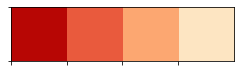

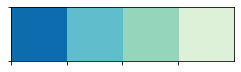

In [23]:
# color palettes for epilepsy and autism

col_pal_a = sns.color_palette("OrRd_r")
col_pal_a = [col_pal_a[0], [sum(x)/2 for x in zip(col_pal_a[1], col_pal_a[2])], col_pal_a[3], col_pal_a[5]]
sns.palplot(col_pal_a)

col_pal_e = sns.color_palette("GnBu_r")
col_pal_e = [col_pal_e[0], col_pal_e[2], col_pal_e[3], col_pal_e[5]]
sns.palplot(col_pal_e)

# Helper Functions

In [24]:
# creates a PPI network using NetworkX given a list of genes 
def create_network(gene_list):
        
    all_genes_df = pd.DataFrame(gene_list)
    all_genes_df.columns = ['gene']
    
    temp = interactions_df.merge(all_genes_df, left_on="protein1", right_on="gene").drop("gene", axis=1)
    e_interactions_df = temp.merge(all_genes_df, left_on="protein2", right_on="gene").drop("gene", axis=1)
    e_interactions_df = e_interactions_df[e_interactions_df["protein1"] != e_interactions_df["protein2"]]
    
    G = nx.Graph()
    G.add_nodes_from(all_genes_df['gene'])
    for index, row in e_interactions_df.iterrows():
        if row['combined_score'] > 0:
            G.add_edge(row['protein1'], row['protein2'], weight=row['combined_score'])
    
    print("There are", len(G.nodes), "nodes in the PPI network")
    print("There are", len(G.edges), "edges in the PPI network")
    
    return G

In [25]:
# function for plotting PPI network
def plot_network(G, m, gene_group_list, colors, label_list, label_colors, legend_titles, d_dict=None, alpha=0.7, figsize=(16,16), font_size=12, font_weight='bold', n=5, legend_size=10, legend_loc='best', save_fig=False, fig_title=None):

    if not d_dict:
        d = dict(G.degree)
    else:
        d = d_dict
        
    plt.figure(figsize=figsize)
    pos = nx.nx_agraph.graphviz_layout(G)
    
    strong_edges = []
    for e in G.edges:
        weight = G[e[0]][e[1]]['weight']
        if weight >= 900:
            strong_edges.append(e)
    
    legend_titles_all = []
    
    # common genes
    common_genes = gene_group_list[-1]
    if len(set(G.nodes).intersection(common_genes)) > 0:
        legend_titles_all.append("Common")
        nx.draw_networkx_nodes(G, pos, nodelist=common_genes, node_size=[m*(d[n]+1) for n in common_genes], node_color=[colors[-1]], alpha=alpha)
    
    # other subgroups of genes
    for i, gene_group in enumerate(gene_group_list[:-1]):
        gene_group = gene_group.difference(common_genes)
        if len(set(G.nodes).intersection(gene_group)) > 0:
            nx.draw_networkx_nodes(G, pos, nodelist=gene_group, node_size=[m*(d[n]+1) for n in gene_group], node_color=[colors[i]], alpha=alpha)
            legend_titles_all.append(legend_titles[i])
            
    # edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color='grey', width=1, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=strong_edges, edge_color='grey', width=2, alpha=0.7)

    # labels
    for i, label in enumerate(label_list):
        nx.draw_networkx_labels(G, pos, labels=label, font_size=font_size, font_color=label_colors[i], font_weight=font_weight)

    plt.legend(legend_titles_all, prop={'size': legend_size}, loc=legend_loc)
    
    if save_fig:
        plt.savefig(FIGURES_DIR + "/" + fig_title + ".png", dpi=300)
        
    plt.show()

In [26]:
# get the connected components of a network
def get_cc(G):
    ccs = sorted(nx.connected_components(G), key=len, reverse=True)
    return ccs

In [27]:
# get modules in network 
def get_coms(G, trials):  
    
    max_coms = None
    max_mod = 0
    
    for i in range(trials):
        weights = []
        for e in G.edges:
            weights.append(G[e[0]][e[1]]['weight'])
        coms = algorithms.leiden(G, weights=weights)
        mod = evaluation.newman_girvan_modularity(G, coms)
        if mod.score > max_mod:
            max_mod = mod.score
            max_coms = coms
        
    max_coms.communities.sort(key = lambda x: (-1 * len(x), x[0]))
    
    return max_coms

In [28]:
# get dataframe of genes, what module they belong to, and whether they are an epilepsy, autism, or common gene
def get_gene_info(G, coms, epilepsy, autism):
    
    nodes = list(G.nodes)
    node_df = pd.DataFrame(nodes) 

    v = []
    for n in nodes:
        idx = 1
        for mod in coms.communities:
            if n in mod:
                v.append(idx)
                break
            idx += 1
        
    # module       
    node_df["module"] = list(v)
    node_df.columns = ["node", "module"]
    
    # type
    gene_types = []
    for n in nodes:
        if n in epilepsy and n in autism:
            gene_types.append("c")
        elif n in epilepsy:
            gene_types.append("e")
        elif n in autism:
            gene_types.append("a")
        else:
            print("ERROR:", n)
    
    node_df["type"] = gene_types
    
    return node_df

In [29]:
# get degree and betweenness centrality of genes in network
def get_network_stats(G, coms, e_groups, a_groups):
    
    node_df = pd.DataFrame({"node": list(G.nodes)})
    node_df = node_df.sort_values(by='node').reset_index().drop("index", axis=1)
    
    # degree
    degrees = list(G.degree(G.nodes))
    degrees_sorted = sorted(degrees, key=lambda x: x[1], reverse=True)
    degrees_sorted_by_gene = sorted(degrees, key=lambda x: x[0])
    degrees_sorted_list = [i[1] for i in degrees_sorted]
    degrees_sorted_by_gene_list = [i[1] for i in degrees_sorted_by_gene]
    node_df["degree"] = degrees_sorted_by_gene_list
    
    # betweenness centrality
    betweenness_centrality = networkx.algorithms.centrality.betweenness_centrality(G, weight="weight")
    betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    betweenness_centrality_sorted_by_gene = sorted(betweenness_centrality.items(), key=lambda x: x[0])
    bc_sorted_by_gene_list = [i[1] for i in betweenness_centrality_sorted_by_gene]
    node_df['betweenness'] = bc_sorted_by_gene_list
    
    gene_types = []
    for n in sorted(G.nodes):
        
        gtype = ""
        idx = 1
        for group in e_groups:
            if n in group:
                gtype += "Epilesy " + str(idx) + ", "
            idx += 1
            
        idx = 1
        for group in a_groups:
            if n in group:
                if idx == 4:
                    gtype += "Autism S, "
                else:
                    gtype += "Autism " + str(idx) + ", "
            idx += 1
        
        gtype = gtype[:-2]
        gene_types.append(gtype)
    
    node_df['type'] = gene_types
    
    return node_df
    

In [30]:
# test for enrichment in a gene group given a distribution of the genes among the modules
def test_enrichement(distribution, coms):
    
    p_vals = []
    enrichment = []
    
    M = sum([len(com) for com in coms.communities]) # population size
    n = sum(distribution) # number of successes in population

    for i, com in enumerate(coms.communities):
        x = distribution[i] # number of drawn successes
        N = len(com) # sample size

        mean = hypergeom.mean(M, n, N, loc=0)

        pval = -1
        if x < mean:
            pval = hypergeom.cdf(x, M, n, N)
            enrichment.append(-1) # less than expected
        else:
            pval = hypergeom.sf(x-1, M, n, N)
            enrichment.append(1) # more then expected
            
        p_vals.append(pval)
        
    return p_vals, enrichment

In [31]:
# get a normalized distribution of a gene group among the modules
def get_distribution_normalized(group):
    distribution = []
    for com in leiden_coms.communities:
        
        num_genes = len(com)
        num_group = len(set(com).intersection(group))

        if num_group == 0:
            distribution.append(0)
        else:  
            distribution.append((num_group/len(group))/num_genes)
    
    return distribution

In [32]:
# get a non-normalized distribution of a gene group among the modules
def get_distribution_total(group, coms):
    distribution = [len(set(com).intersection(group)) for com in coms.communities]
    return distribution

In [33]:
# get which modules are enriched in a certain gene group
def get_enriched_modules(pvals, enrichment, alpha):
    enriched_modules = []
    for i in range(len(pvals)):
        if enrichment[i] == 1 and pvals[i] < alpha:
            enriched_modules.append(i+1)
        
    return enriched_modules

In [34]:
# plot the distribution of a gene group among the modules
def plot_distribution(distribution_list, distribution_labels, enriched_modules, pvals, module_cutoff, col_pal, y_axes_col, y_labels, y_lims=None, scatter=None, save_fig=False, fig_title=None):

    matplotlib.rcParams.update({'font.size': 20})
    fig, ax1 = plt.subplots(figsize=(14,8))
    index = np.arange(module_cutoff)
    
    if len(distribution_list) > 2:
        bar_width = 0.2
    else:
        bar_width = 0.3
    opacity = 0.8

    for i, distribution in enumerate(distribution_list):
        rects = ax1.bar(index + i*bar_width, distribution[:module_cutoff], bar_width, alpha=opacity, color=col_pal[i], label=distribution_labels[i])
        
        if len(distribution_list) == len(pvals):
            for j, rect in enumerate(rects, 1):
                if j in enriched_modules[i]:
                    height = rect.get_height()
                    if pvals[i][j-1] < 0.01:
                        plt.text(rect.get_x() + rect.get_width()/2.0, height, '**', ha='center', va='bottom')
                    else:
                        plt.text(rect.get_x() + rect.get_width()/2.0, height, '*', ha='center', va='bottom')
    
    # one p-value for all bars
    if len(distribution_list) != len(pvals):
        for j, rect in enumerate(rects, 1):
            if j in enriched_modules[0]:
                height = rect.get_height()
                if pvals[0][j-1] < 0.01:
                    plt.text(index[j-1], height, '**', ha='center', va='bottom')
                else:
                    plt.text(index[j-1], height, '*', ha='center', va='bottom')

    ax1.set_xlabel('Module')
    x_tick_labels = [str(i) for i in range(1, module_cutoff + 1)]
    x_ticks = index + (bar_width*(len(distribution_list)-1))/2
    
    color = y_axes_col[0]
    ax1.set_ylabel(y_labels[0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc="upper center")
    
    if y_lims:
        ax1.set_ylim(y_lims[0])

    if scatter:
        ax2 = ax1.twinx()
        color = y_axes_col[1]
        ax2.scatter(x_ticks, scatter[:module_cutoff], color=color)
        ax2.set_ylabel(y_labels[1], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(y_lims[1])
    
    plt.xticks(x_ticks, x_tick_labels)    
    fig.tight_layout()
    
    if save_fig:
        plt.savefig(FIGURES_DIR + "/" + fig_title + ".png", dpi=300)
    plt.show()

In [35]:
# get -log10(pvalues) for positive enrichment and +log10(pvalues) for negative enrichment
def get_log_pvals(pvals, enrichment, module_cutoff=17):
    log_pvals = []
    for i in range(module_cutoff):
        if enrichment[i] == 1:
            log_pvals.append(-np.log10(pvals[i]))
        else:
            log_pvals.append(np.log10(pvals[i]))
    return log_pvals

In [36]:
# plot gene ontology (GO) terms
def plot_GO_term(GO_terms, pvals, counts, xlim, save_fig=False, fig_title=None):

    bar_width = 0.5
    labelsize = 12
    y_pos = np.arange(len(GO_terms))

    fig, ax1 = plt.subplots(figsize=(12,8))
    ax1.tick_params(axis='both', which='major', labelsize=labelsize)
    ax1.tick_params(axis='both', which='minor', labelsize=labelsize)
    bar1 = ax1.barh(y_pos, -np.log10(pvals), bar_width, align='center', color="lightblue", alpha=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(GO_terms)
    ax1.invert_yaxis()  
    ax1.set_xlabel('-log10(p-value)')

    ax2 = ax1.twiny()
    ax2.tick_params(axis='both', which='major', labelsize=labelsize)
    ax2.tick_params(axis='both', which='minor', labelsize=labelsize)
    color = "purple"
    ax2.scatter(counts, y_pos, color=color)
    ax2.set_xlabel('Number of genes', color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    
    if xlim:
        ax2.set_xlim(xlim)

    fig.tight_layout()

    plt.savefig(FIGURES_DIR + "/" + fig_title + ".png", dpi=300)
    plt.show()

# Create the epilepsy-autism PPI network

In [37]:
all_genes = epilepsy_genes.union(autism_genes)
common_genes = epilepsy_genes.intersection(autism_genes)

In [38]:
print("In the epilepsy-autism STRING PPI network:")
print("Number of epilepsy-associated genes:", len(epilepsy_genes))
print("Number of autism-associated genes:", len(autism_genes))
print("Number of common genes (associated with both epilepsy and autism):", len(common_genes))
print("Total number of genes (all genes):", len(all_genes))

In the epilepsy-autism STRING PPI network:
Number of epilepsy-associated genes: 998
Number of autism-associated genes: 903
Number of common genes (associated with both epilepsy and autism): 204
Total number of genes (all genes): 1697


In [39]:
# create epilepsy-autism PPI network
groups_e1234_as123 = [group_e1, group_e2, group_e3, group_e4, group_a1, group_a2, group_a3, group_as, common_genes]
E1234AS123 = create_network(all_genes)

There are 1697 nodes in the PPI network
There are 7903 edges in the PPI network


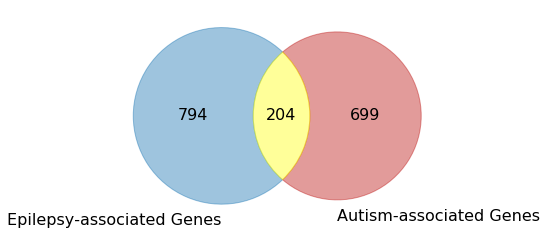

In [40]:
# venn diagram of epilepsy- and autism-associated genes

c = venn2([epilepsy_genes, autism_genes], set_labels = ('Epilepsy-associated Genes', 'Autism-associated Genes'))
c.get_patch_by_id('10').set_color(col_pal_e[0])
c.get_patch_by_id('01').set_color(col_pal_a[0])
c.get_patch_by_id('11').set_color("yellow")

for text in c.set_labels:
    text.set_fontsize(16)
for text in c.subset_labels:
    text.set_fontsize(16)
    
plt.savefig(FIGURES_DIR + "/venn_diagram.png", dpi=300)

In [41]:
# get the largest connected component in the epilepsy-autism PPI network
E1234AS123_ccs = get_cc(E1234AS123)
E1234AS123_largest_cc_genes = set(E1234AS123_ccs[0])
E1234AS123_largest_cc = E1234AS123.subgraph(E1234AS123_largest_cc_genes)

In [42]:
print("Total number of genes in the largest connected component (lcc) of the epilepsy-autism PPI network:", len(E1234AS123_largest_cc_genes))
print("Number of epilepsy-associated genes in the lcc:", len(E1234AS123_largest_cc_genes.intersection(epilepsy_genes)))
print("number of autism-associated genes in the lcc:", len(E1234AS123_largest_cc_genes.intersection(autism_genes)))
print("number of common genes in the lcc:", len(E1234AS123_largest_cc_genes.intersection(common_genes)))

Total number of genes in the largest connected component (lcc) of the epilepsy-autism PPI network: 1374
Number of epilepsy-associated genes in the lcc: 834
number of autism-associated genes in the lcc: 724
number of common genes in the lcc: 184


/opt/anaconda3/envs/ea-ppi/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


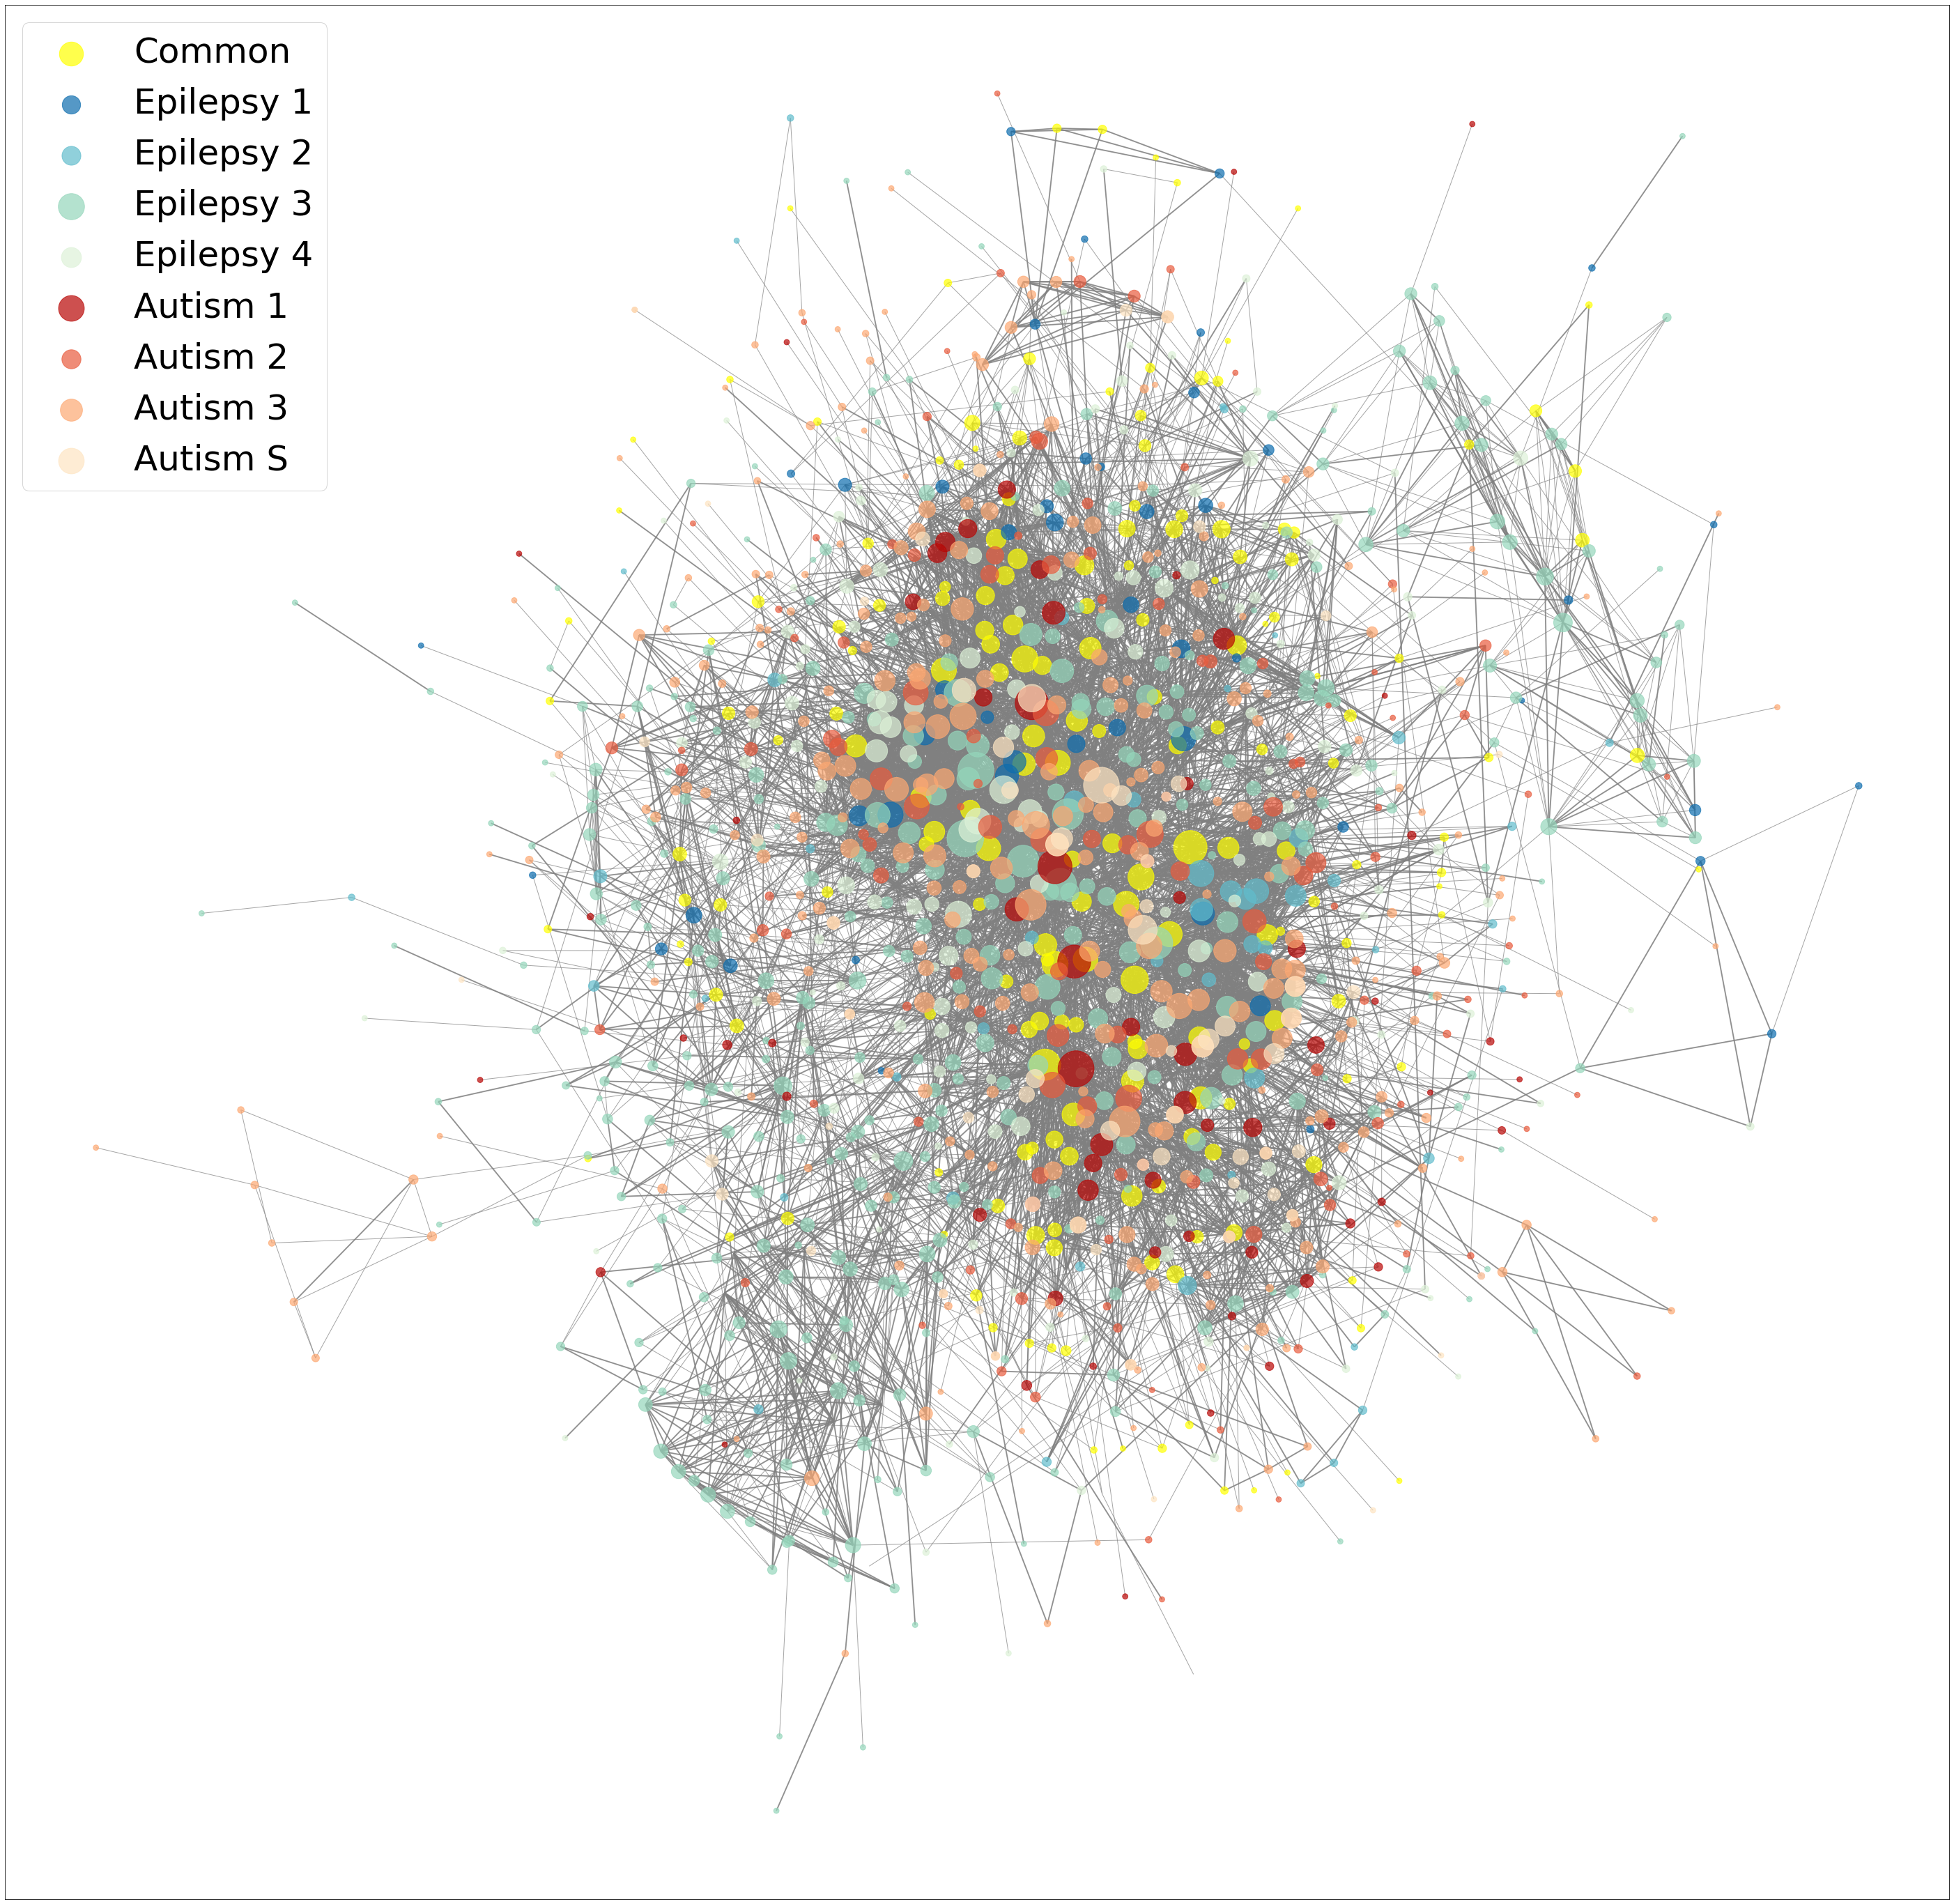

In [43]:
# plot the largest component in the epilepsy-autism PPI network
plot_network(E1234AS123_largest_cc, 30, [E1234AS123_largest_cc_genes.intersection(group) for group in groups_e1234_as123], col_pal_e + col_pal_a + ["yellow"], [], [],
             ["Epilepsy 1", "Epilepsy 2", "Epilepsy 3", "Epilepsy 4", "Autism 1", "Autism 2", "Autism 3", "Autism S"], figsize=(50,50), legend_size=50, save_fig=True, fig_title="largest_connected_component")

# Generate modules in the epilepsy-autism PPI network

### Change REGENERATE_MODULES to True if you want to rerun leiden algorithm for community detection

In [44]:
REGENERATE_MODULES = False

if REGENERATE_MODULES:
    leiden_coms = get_coms(E1234AS123, 1000)
    gene_info = get_gene_info(E1234AS123, leiden_coms, epilepsy_genes, autism_genes)
    gene_info.to_csv(OUTPUT_DIR + "/gene_info_all_genes_new.tsv", sep='\t', index=False)
    modules_df = pd.read_csv(OUTPUT_DIR + "/gene_info_all_genes_new.tsv", sep="\t")

# get the modules specified in the paper from gene_info_all_genes.tsv
else:
    modules_df = pd.read_csv("gene_info_all_genes.tsv", sep="\t")

In [45]:
PPI_genes = set(modules_df["node"])
print("Number of genes in the epilepsy-autism PPI network:", len(PPI_genes))

num_modules = max(modules_df["module"])
print("Number of modules in the epilepsy-autism PPI network:", num_modules)

Number of genes in the epilepsy-autism PPI network: 1697
Number of modules in the epilepsy-autism PPI network: 326


In [46]:
# define the communities
communities = []
for i in range(num_modules):
    communities.append([])

for i, row in modules_df.iterrows():
    module = row["module"]
    gene = row["node"]
    communities[module - 1].append(gene)

class leiden_coms:
    communities = []
    
leiden_coms.communities = communities

In [47]:
# modularity score
print("The Newman-Girvan modularity score is", evaluation.newman_girvan_modularity(E1234AS123, leiden_coms).score)

The Newman-Girvan modularity score is 0.6781416531240215


# Enrichment analysis of epilepsy and autism subgroups

In [48]:
# only look into largest 17 modules
MODULE_CUTOFF = 17

In [49]:
# size of each community
coms_size = [len(com) for com in leiden_coms.communities]

### Epilepsy subgroups

In [50]:
# Epilepsy 1
pvals_e1, enrichment_e1 = test_enrichement(get_distribution_total(group_e1, leiden_coms), leiden_coms)
enriched_modules_e1 = get_enriched_modules(pvals_e1, enrichment_e1, alpha=0.05)

# Epilepsy 2
pvals_e2, enrichment_e2 = test_enrichement(get_distribution_total(group_e2, leiden_coms), leiden_coms)
enriched_modules_e2 = get_enriched_modules(pvals_e2, enrichment_e2, alpha=0.05)

# Epilepsy 3
pvals_e3, enrichment_e3 = test_enrichement(get_distribution_total(group_e3, leiden_coms), leiden_coms)
enriched_modules_e3 = get_enriched_modules(pvals_e3, enrichment_e3, alpha=0.05)

# Epilepsy 4
pvals_e4, enrichment_e4 = test_enrichement(get_distribution_total(group_e4, leiden_coms), leiden_coms)
enriched_modules_e4 = get_enriched_modules(pvals_e4, enrichment_e4, alpha=0.05)

In [51]:
# get normalized distribution of epilepsy subgroups
distribution_e1 = get_distribution_normalized(group_e1)
distribution_e2 = get_distribution_normalized(group_e2)
distribution_e3 = get_distribution_normalized(group_e3)
distribution_e4 = get_distribution_normalized(group_e4)

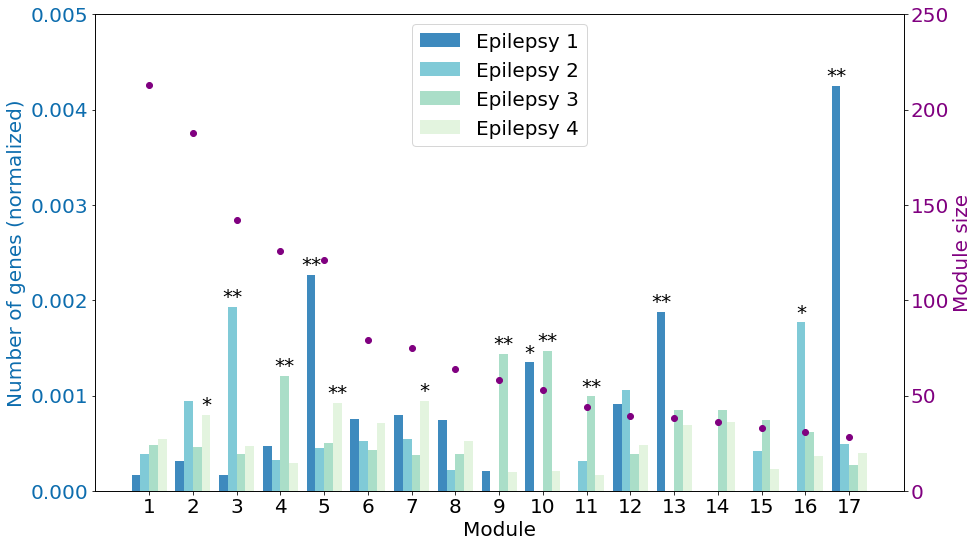

In [52]:
distribution_list = [distribution_e1, distribution_e2, distribution_e3, distribution_e4]
distribution_labels = ["Epilepsy 1", "Epilepsy 2", "Epilepsy 3", "Epilepsy 4"]
enriched_modules = [enriched_modules_e1, enriched_modules_e2, enriched_modules_e3, enriched_modules_e4]
pvals = [pvals_e1, pvals_e2, pvals_e3, pvals_e4]
y_labels = ["Number of genes (normalized)", "Module size"]
y_lims = [(0, 0.005), (0, 250)]
y_axes_col = [col_pal_e[0], "purple"]
plot_distribution(distribution_list, distribution_labels, enriched_modules, pvals, MODULE_CUTOFF, col_pal_e, y_axes_col, y_labels, y_lims, scatter=coms_size, save_fig=True, fig_title="epilepsy_distribution")


### Autism subgroups

In [53]:
# Autism 1
pvals_a1, enrichment_a1 = test_enrichement(get_distribution_total(group_a1, leiden_coms), leiden_coms)
enriched_modules_a1 = get_enriched_modules(pvals_a1, enrichment_a1, alpha=0.05)

# Autism 2
pvals_a2, enrichment_a2 = test_enrichement(get_distribution_total(group_a2, leiden_coms), leiden_coms)
enriched_modules_a2 = get_enriched_modules(pvals_a2, enrichment_a2, alpha=0.05)

# Autism 3
pvals_a3, enrichment_a3 = test_enrichement(get_distribution_total(group_a3, leiden_coms), leiden_coms)
enriched_modules_a3 = get_enriched_modules(pvals_a3, enrichment_a3, alpha=0.05)

# Autism S
pvals_as, enrichment_as = test_enrichement(get_distribution_total(group_as, leiden_coms), leiden_coms)
enriched_modules_as = get_enriched_modules(pvals_as, enrichment_as, alpha=0.05)

In [54]:
# get normalized distribution of autism subgroups
distribution_a1 = get_distribution_normalized(group_a1)
distribution_a2 = get_distribution_normalized(group_a2)
distribution_a3 = get_distribution_normalized(group_a3)
distribution_as = get_distribution_normalized(group_as)

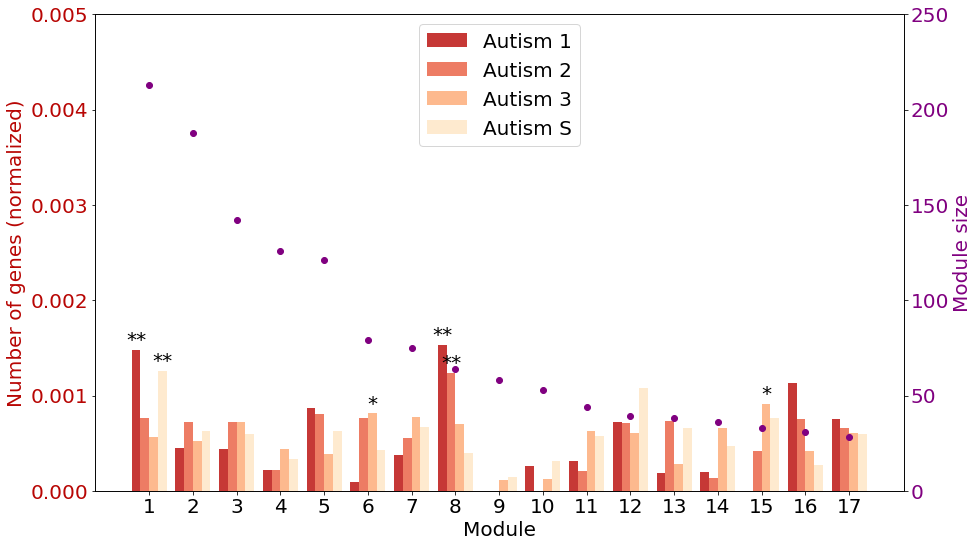

In [55]:
distribution_list = [distribution_a1, distribution_a2, distribution_a3, distribution_as]
distribution_labels = ["Autism 1", "Autism 2", "Autism 3", "Autism S"]
enriched_modules = [enriched_modules_a1, enriched_modules_a2, enriched_modules_a3, enriched_modules_as]
pvals = [pvals_a1, pvals_a2, pvals_a3, pvals_as]
y_labels = ["Number of genes (normalized)", "Module size"]
y_lims = [(0, 0.005), (0, 250)]
y_axes_col = [col_pal_a[0], "purple"]
plot_distribution(distribution_list, distribution_labels, enriched_modules, pvals, MODULE_CUTOFF, col_pal_a, y_axes_col, y_labels, y_lims, scatter=coms_size, save_fig=True, fig_title="autism_distribution")


# Enrichment analysis of common genes

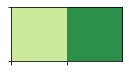

In [56]:
col_pal = sns.color_palette("YlGn_r")
col_pal = [col_pal[4], col_pal[1]]
sns.palplot(col_pal)

In [57]:
# create dataframe with number of common genes in each module
num_common_genes_in_modules = []
for com in leiden_coms.communities:
    num_common_genes_in_modules.append(len(set(com).intersection(common_genes)))
    
common_module_df = pd.DataFrame({"module": list(range(1,num_modules+1)), "num_common": num_common_genes_in_modules})
common_module_df["module_size"] = coms_size
common_module_df["num_common_normalized"] = common_module_df["num_common"] / common_module_df["module_size"]

In [58]:
# expected number of common genes in a module is total number of genes in the module * (total number of common genes) / (total number of all genes) 
p_c = len(common_genes) / len(all_genes)
expected_common = [round(p_c*size) for size in coms_size]

In [59]:
distribution_c = get_distribution_total(common_genes, leiden_coms)
pvals_c, enrichment_c = test_enrichement(distribution_c, leiden_coms)
enriched_modules_c = get_enriched_modules(pvals_c, enrichment_c, alpha=0.05)

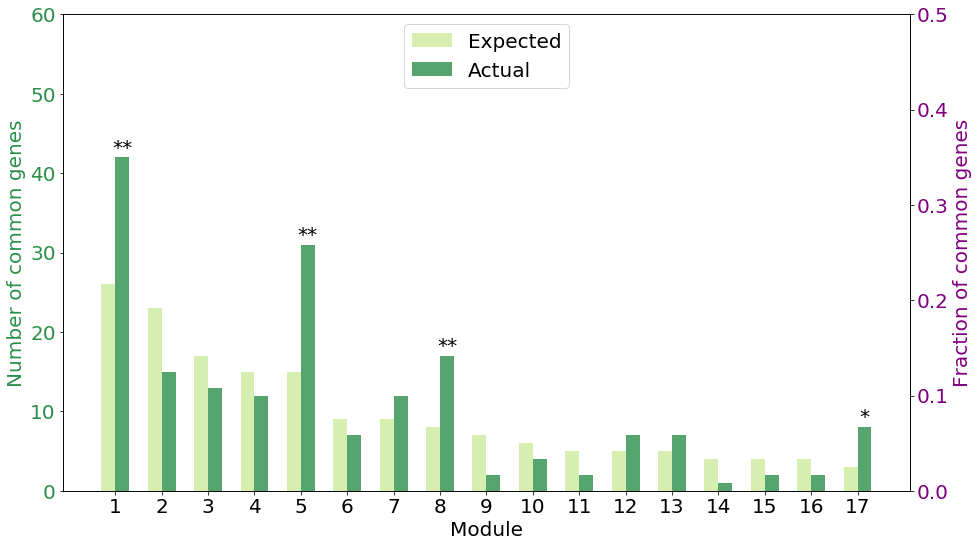

In [60]:
distribution_list = [expected_common, distribution_c]
distribution_labels = ["Expected", "Actual"]
enriched_modules = [[], enriched_modules_c]
pvals = [[], pvals_c]
y_labels = ["Number of common genes", "Fraction of common genes"]
y_lims = [(0,60), (0, 0.5)]
y_axes_col = [col_pal[1], "purple"]
plot_distribution(distribution_list, distribution_labels, enriched_modules, pvals, MODULE_CUTOFF, col_pal, y_axes_col, y_labels, y_lims, scatter=coms_size, save_fig=True, fig_title="common_distribution")



# Enrichment analysis of differentially expressed genes (DEGs)

In [61]:
expression_df = pd.read_csv("DE_genes.csv")

In [62]:
DE_genes = set(expression_df["Row.names"].values)
print("Number of differentially expressed genes (DEGs):", len(DE_genes))

Number of differentially expressed genes (DEGs): 263


In [63]:
# count number of DEGs in each module and format in dataframe
count = pd.DataFrame(expression_df.groupby(['module'])["Row.names"].count()).reset_index()
count.columns = ["module", "num_DEGs"]
temp = pd.DataFrame({"module":list(range(1,num_modules+1))})
expression_module_df = count.merge(temp, how="outer")

In [64]:
# count number of upregulated DEGs in each module and format in dataframe
expression_up_df = expression_df[expression_df["logFC"] > 0]
count = pd.DataFrame(expression_up_df.groupby(['module'])["Row.names"].count()).reset_index()
count.columns = ["module", "num_DEGs_up"]
expression_module_df = count.merge(expression_module_df, how="outer")

In [65]:
# count number of downregulated DEGs in each module and format in dataframe
expression_down_df = expression_df[expression_df["logFC"] < 0]
count = pd.DataFrame(expression_down_df.groupby(['module'])["Row.names"].count()).reset_index()
count.columns = ["module", "num_DEGs_down"]
expression_module_df = count.merge(expression_module_df, how="outer")

In [66]:
expression_module_df= expression_module_df.fillna(0)
expression_module_df = expression_module_df.sort_values(by="module")
expression_module_df["module_size"] = coms_size
expression_module_df["num_DEGs_normalized"] = expression_module_df["num_DEGs"] / expression_module_df["module_size"]

In [67]:
pvals_DE, enrichment_DE = test_enrichement(get_distribution_total(DE_genes, leiden_coms), leiden_coms)
enriched_modules_DE = get_enriched_modules(pvals_DE, enrichment_DE, alpha=0.05)

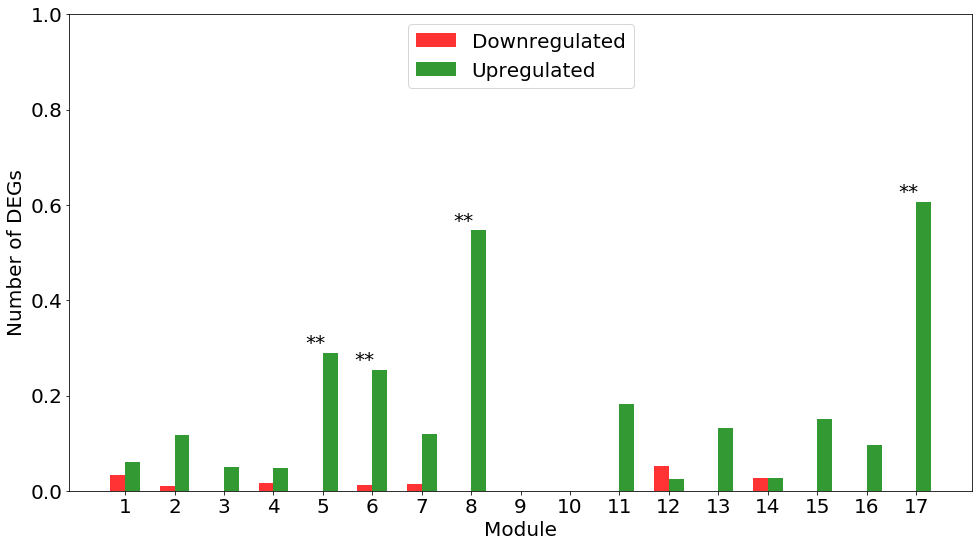

In [68]:
downregulated = list(expression_module_df["num_DEGs_down"]/expression_module_df["module_size"])
upregulated = list(expression_module_df["num_DEGs_up"]/expression_module_df["module_size"])

distribution_list = [downregulated, upregulated]
distribution_labels = ["Downregulated", "Upregulated"]
enriched_modules = [enriched_modules_DE]
pvals = [pvals_DE]
y_labels = ["Number of DEGs"]
y_lims = [(0,1)]
y_axes_col = ["black"]
plot_distribution(distribution_list, distribution_labels, enriched_modules, pvals, MODULE_CUTOFF, ["red", "green"], y_axes_col, y_labels, y_lims, scatter=None, save_fig=True, fig_title="DEG_distribution")


# Get network statistics of genes in epilepsy-autsim PPI network

In [69]:
e_groups = [group_e1, group_e2, group_e3, group_e4]
a_groups = [group_a1, group_a2, group_a3, group_as]
network_stats = get_network_stats(E1234AS123, leiden_coms, e_groups, a_groups)

# k-core (k=17) in epilepsy-autism PPI Network

### change GENERATE_K_CORE_FIGURE to True to get a plot of degree vs modularity for different values of k for k-core

In [70]:
GENERATE_K_CORE_FIGURE = False

if GENERATE_K_CORE_FIGURE:
    
    G = E1234AS123
    experiment_mod = []
    experiment_coms = []
    degrees_range = range(10, 28)

    for i in range(100):

        if i % 5 == 0:
            print(i)

        modularities = []
        num_coms = []

        for k in degrees_range:
            k_core = nx.algorithms.core.k_core(G, k=k)
            coms = algorithms.louvain(k_core, weight='weight', resolution=1.0, randomize=True)
            mod = evaluation.newman_girvan_modularity(k_core, coms).score
            modularities.append(mod)
            num_coms.append(len(coms.communities))

        experiment_mod.append(modularities)
        experiment_coms.append(num_coms)

    mod_mean = []
    mod_std = []

    com_mean = []
    com_std = []

    for i in range(len(experiment_mod[0])):
        mod_mean.append(np.mean([j[i] for j in experiment_mod]))
        mod_std.append(np.std([j[i] for j in experiment_mod]))

        com_mean.append(np.mean([j[i] for j in experiment_coms]))
        com_std.append(np.std([j[i] for j in experiment_coms]))

In [71]:
if GENERATE_K_CORE_FIGURE:
    matplotlib.rcParams.update({'font.size': 20})

    fig, ax1 = plt.subplots(figsize=(12,8))

    ax1.set_xlabel('Degree ($k$)')
    color = "red"
    ax1.set_ylabel('Modularity', color=color)
    ax1.errorbar(degrees_range, mod_mean, yerr=mod_std, color=color, linestyle="", marker="o")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = "blue"
    ax2.set_ylabel('Number of Modules', color=color)
    ax2.errorbar(degrees_range, com_mean, yerr=com_std, color=color, linestyle="", marker="o")
    ax2.tick_params(axis='y', labelcolor=color)

    plt.xticks(degrees_range)
    ax1.set_ylim((0.5, 0.7))

    fig.tight_layout() 
    plt.savefig(FIGURES_DIR + "/k_core_degree_vs_modularity.png", dpi=300)
    plt.show()

In [72]:
k_core_17 = nx.algorithms.core.k_core(E1234AS123, k=17)
k_core_17_genes = set(k_core_17.nodes)
print("There are", len(k_core_17.nodes), "nodes in the k-core (k=17).")
print("There are", len(k_core_17.edges), "edges in the k-core (k=17).")

There are 142 nodes in the k-core (k=17).
There are 1698 edges in the k-core (k=17).


In [73]:
# overlap genes are genes that are differentially expressed and in the k-core
overlap_genes = DE_genes.intersection(k_core_17_genes)
print("Number of overlap genes (DE genes in k-core):", len(overlap_genes))

Number of overlap genes (DE genes in k-core): 24


In [74]:
non_overlap_genes = k_core_17_genes.difference(overlap_genes)

In [75]:
print("Overlap genes (both differentially expressed and in k-core):")

print("E1:", overlap_genes.intersection(group_e1))
print("E2:", overlap_genes.intersection(group_e2))
print("E3:", overlap_genes.intersection(group_e3))
print("E4:", overlap_genes.intersection(group_e4))
print()
print("A1:", overlap_genes.intersection(group_a1))
print("A2:", overlap_genes.intersection(group_a2))
print("A3:", overlap_genes.intersection(group_a3))
print("AS:", overlap_genes.intersection(group_as))

Overlap genes (both differentially expressed and in k-core):
E1: set()
E2: set()
E3: {'AVPR2', 'GRM1', 'LRP2', 'NRXN1'}
E4: {'HTR1A', 'HTR2A', 'OPRM1', 'GABBR2', 'SHANK1', 'PDYN', 'NLGN1'}

A1: {'SHANK2', 'NRXN3', 'NRXN1'}
A2: {'SHANK1', 'DLGAP1', 'NLGN4X', 'NLGN1'}
A3: {'GABBR2', 'GPR37', 'CHRM3', 'GRM5', 'HTR1B', 'DLGAP3', 'GRM7', 'DRD2', 'DLGAP2', 'LRP2'}
AS: {'GABBR2', 'SYT1'}


In [76]:
non_overlap_genes_label = {}
for g in non_overlap_genes:
    non_overlap_genes_label[g] = g
    
overlap_genes_label = {}
for g in overlap_genes:
    overlap_genes_label[g] = g
    

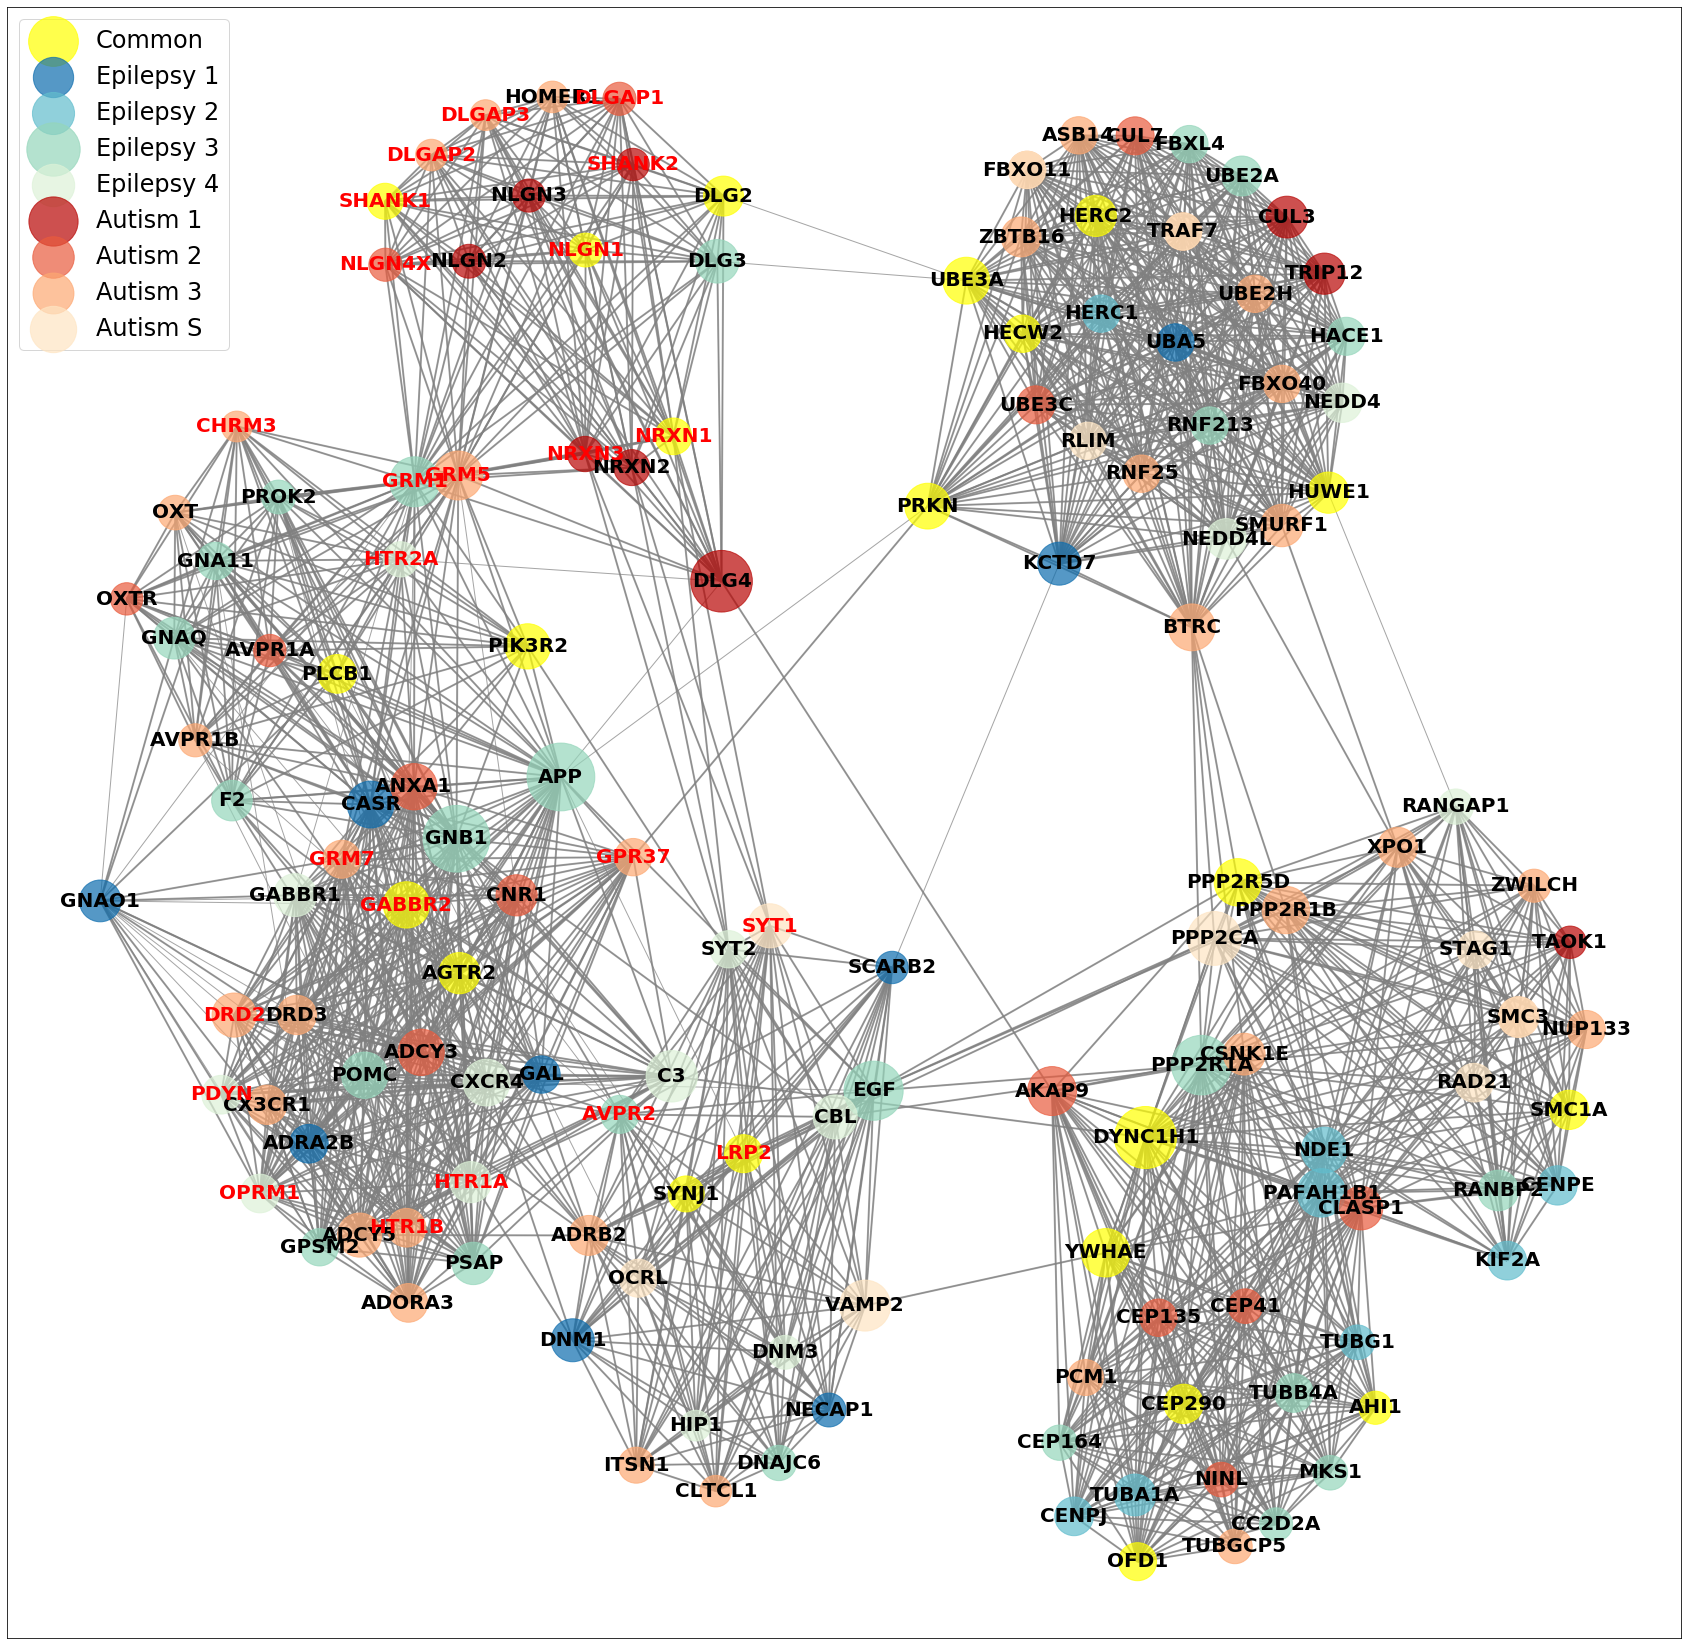

In [77]:
# plot k-core
plot_network(k_core_17, 50, [set(k_core_17.nodes).intersection(set(group)) for group in groups_e1234_as123], col_pal_e + col_pal_a + ["yellow"], 
             [non_overlap_genes_label, overlap_genes_label], ["black", "red"],
             ["Epilepsy 1", "Epilepsy 2", "Epilepsy 3", "Epilepsy 4", "Autism 1", "Autism 2", "Autism 3", "Autism S"],
             d_dict = dict(E1234AS123.degree), alpha=0.7, figsize=(30,30), font_size=20, font_weight='bold', legend_size=24, legend_loc="upper left", save_fig=True, fig_title="k_core")


### Modules in the k-core

In [78]:
if REGENERATE_MODULES:
    k_core_coms = get_coms(k_core_17, 1000)
    k_core_17_info = get_gene_info(k_core_17, k_core_coms, epilepsy_genes, autism_genes)
    k_core_17_info.to_csv(OUTPUT_DIR + "/gene_info_k_17_all_genes_new.tsv", sep='\t', index=False)
    k_core_17_df = pd.read_csv(OUTPUT_DIR + "/gene_info_k_17_all_genes_new.tsv", sep="\t")

# get the k-core modules specified in the paper from gene_info_k_17_with_modules.tsv
else:
    k_core_17_df = pd.read_csv("gene_info_k_17_with_modules.tsv", sep="\t")

In [79]:
num_modules = max(k_core_17_df["module"])
print("Number of modules:", num_modules)

communities = []
for i in range(num_modules):
    communities.append([])

for i, row in k_core_17_df.iterrows():
    module = row["module"]
    gene = row["node"]
    communities[module - 1].append(gene)

class k_core_17_coms:
    communities = []
    
k_core_17_coms.communities = communities

Number of modules: 5


# Module 8 analysis

In [80]:
MODULE = 8
M8_genes = set(leiden_coms.communities[MODULE-1])
M8 = E1234AS123.subgraph(M8_genes)

In [81]:
M8_network_stats = network_stats[network_stats["node"].isin(M8_genes)]
M8_network_stats["k_core"] = M8_network_stats["node"].isin(k_core_17_genes)
M8_network_stats["DE"] = M8_network_stats["node"].isin(DE_genes)

/opt/anaconda3/envs/ea-ppi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/ea-ppi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
# get top 20 genes in module 8 with highest degree in epilepsy-autism PPI network
M8_top_degree = M8_network_stats[['node', 'degree', 'type', 'k_core', 'DE']].sort_values(by="degree", ascending=False).head(20)


In [83]:
M8_top_degree

node  degree                 type  k_core     DE
404     DLG4      75             Autism 1    True  False
644     GRM1      49            Epilesy 3    True   True
645     GRM5      47             Autism 3    True   True
627    GRIA1      45             Autism 2   False   True
640   GRIN2B      42  Epilesy 1, Autism 1   False   True
403     DLG3      37            Epilesy 3    True  False
206   CAMK2A      35   Autism 3, Autism S   False  False
639   GRIN2A      32  Epilesy 1, Autism 2   False   True
628    GRIA2      32             Autism 2   False   True
402     DLG2      31  Epilesy 4, Autism 2    True  False
207   CAMK2B      31             Autism S   False  False
638    GRIN1      30  Epilesy 3, Autism 2   False   True
401     DLG1      29             Autism 3   False  False
1036   NRXN1      26  Epilesy 3, Autism 1    True   True
1382  SHANK1      25  Epilesy 4, Autism 2    True   True
1037   NRXN2      25             Autism 1    True  False
1038   NRXN3      24             Autism 1    True   True
1011   NLGN1      22  Epilesy 4, Autism 2    True   True
1012   NLGN2      22             Autism 1    True  False
405   DLGAP1      21             Autism 2    True   True

In [84]:
# save genes with highest degree to csv file
M8_top_degree.to_csv(OUTPUT_DIR + "/M8_degree.csv", index=False)

In [85]:
# get top 20 genes in module 8 with highest betwenness centrality (BC) in epilepsy-autism PPI network
M8_top_BC = M8_network_stats[['node', 'betweenness', 'type', 'k_core', 'DE']].sort_values(by="betweenness", ascending=False).head(20)


In [86]:
M8_top_BC

node  betweenness                 type  k_core     DE
404      DLG4     0.026244             Autism 1    True  False
627     GRIA1     0.011278             Autism 2   False   True
640    GRIN2B     0.010893  Epilesy 1, Autism 1   False   True
544      FMR1     0.008942  Epilesy 3, Autism 1   False  False
207    CAMK2B     0.005781             Autism S   False  False
644      GRM1     0.005608            Epilesy 3    True   True
401      DLG1     0.005361             Autism 3   False  False
206    CAMK2A     0.005103   Autism 3, Autism S   False  False
1308     RELN     0.002910  Epilesy 2, Autism 1   False  False
628     GRIA2     0.002856             Autism 2   False   True
638     GRIN1     0.002792  Epilesy 3, Autism 2   False   True
716       HTT     0.002650            Epilesy 3   False  False
1511  SYNGAP1     0.002624  Epilesy 3, Autism 1   False  False
402      DLG2     0.002508  Epilesy 4, Autism 2    True  False
639    GRIN2A     0.002332  Epilesy 1, Autism 2   False   True
1396   SLC1A2     0.001887  Epilesy 1, Autism S   False   True
1012    NLGN2     0.001751             Autism 1    True  False
714     HTR3A     0.001339             Autism 3   False   True
645      GRM5     0.001230             Autism 3    True   True
1036    NRXN1     0.001221  Epilesy 3, Autism 1    True   True

In [87]:
M8_top_BC.to_csv(OUTPUT_DIR + "/M8_BC.csv", index=False)

In [88]:
M8_DE_genes_label = {}
for g in M8_genes.intersection(DE_genes):
    M8_DE_genes_label[g] = g

/opt/anaconda3/envs/ea-ppi/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


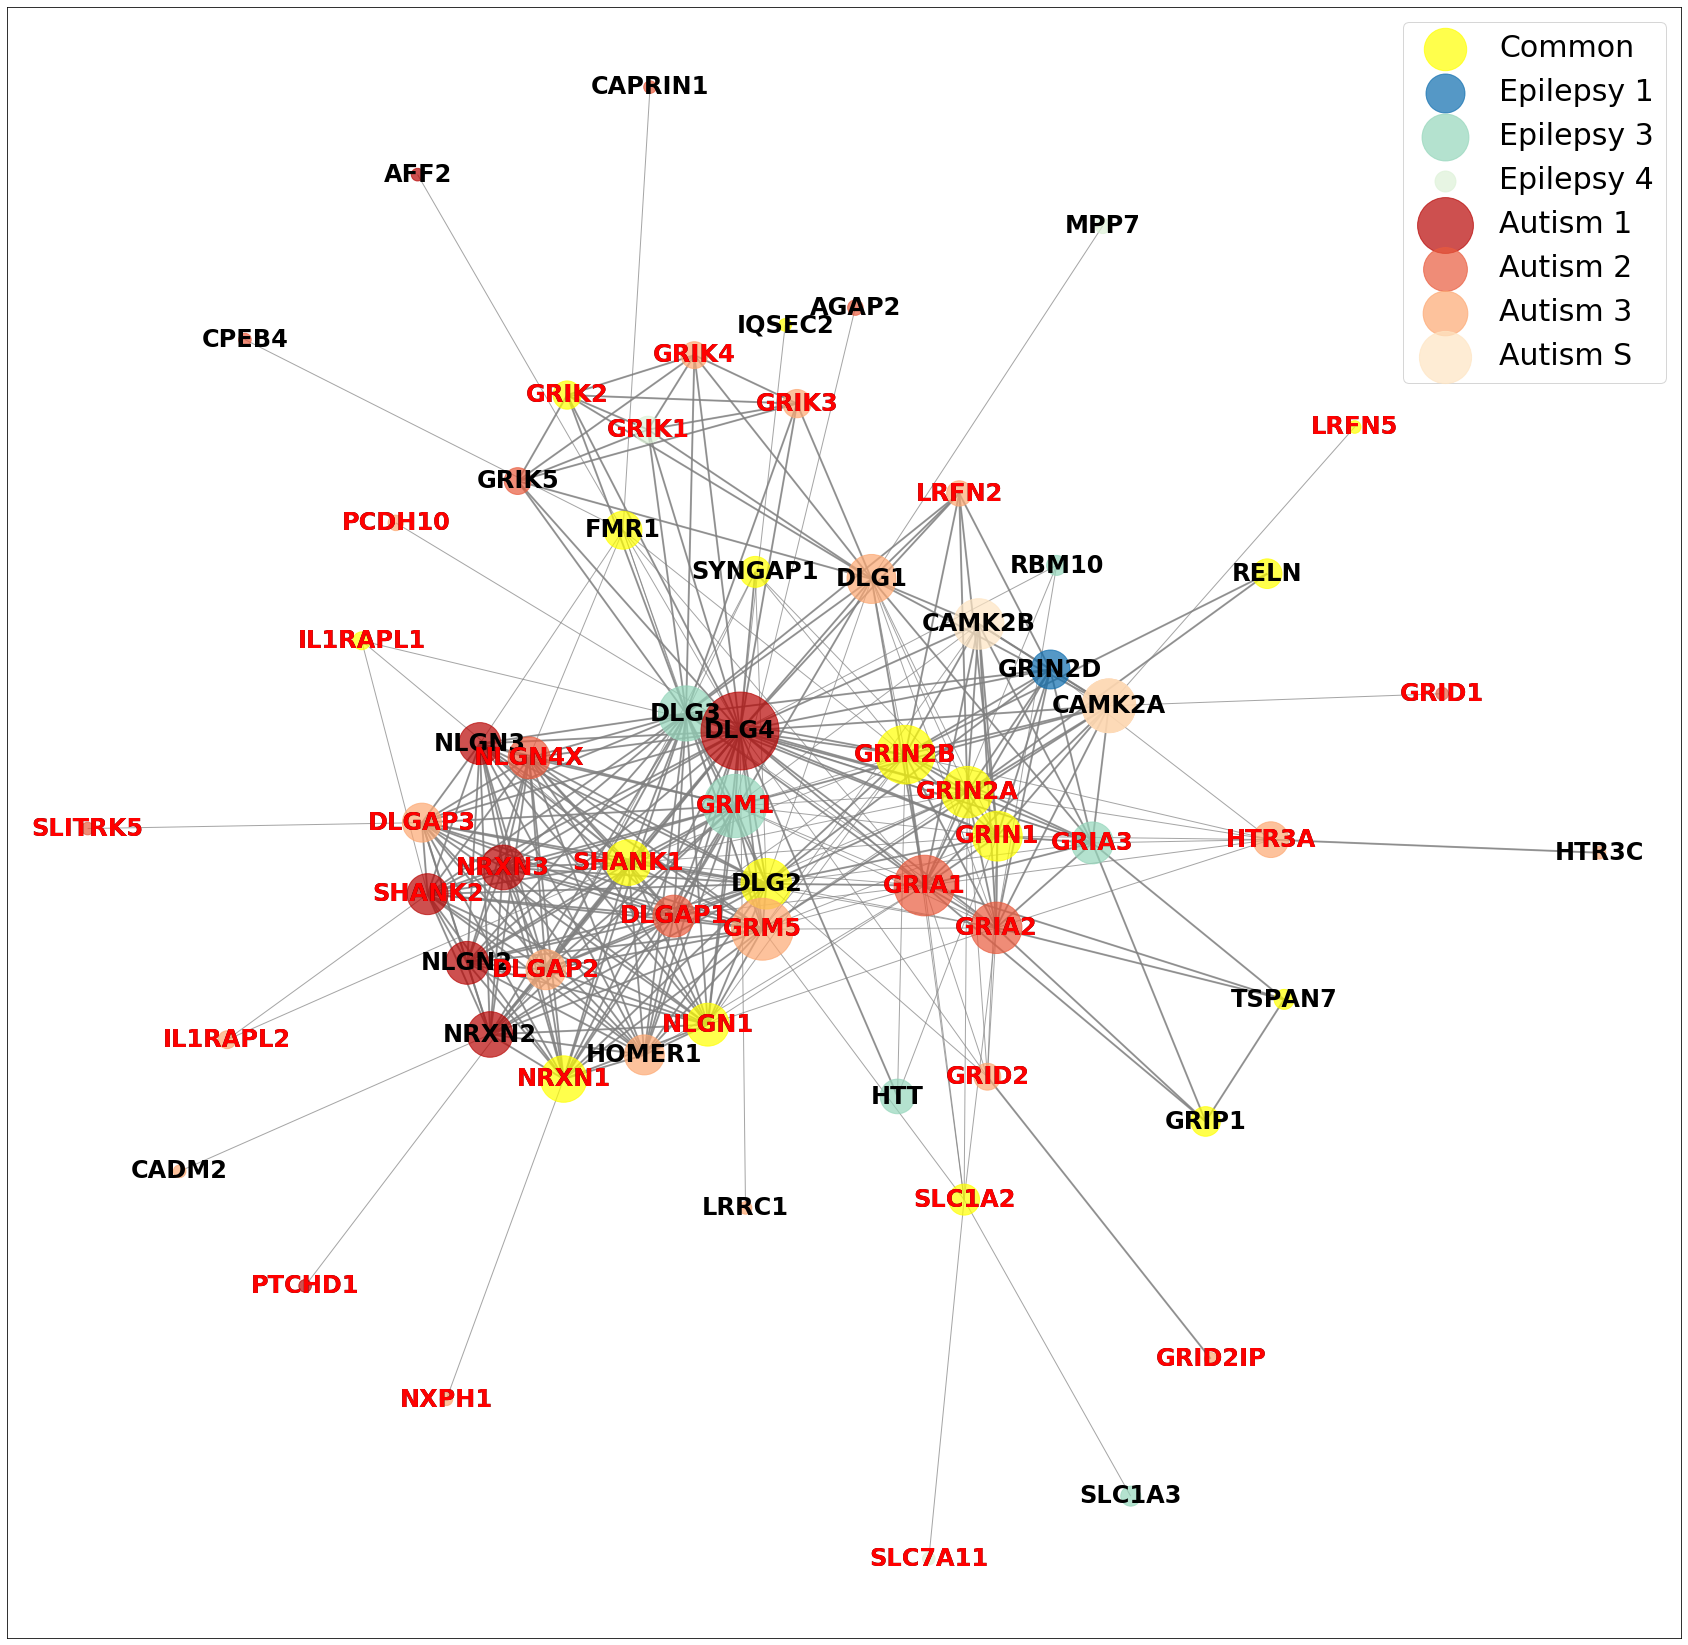

In [89]:
M8_labels = {}
for g in M8.nodes:
    M8_labels[g] = g
plot_network(M8, 80, [set(M8.nodes).intersection(group) for group in groups_e1234_as123], col_pal_e + col_pal_a + ["yellow"], [M8_labels, M8_DE_genes_label], ["black", "red"],
             ["Epilepsy 1", "Epilepsy 2", "Epilepsy 3", "Epilepsy 4", "Autism 1", "Autism 2", "Autism 3", "Autism S"], d_dict = dict(E1234AS123.degree), figsize=(30,30), legend_size=30, font_size=24, save_fig=True, fig_title="module_8")



In [90]:
M8_bp = pd.read_csv("modules_DAVID/8_bp.txt", sep="\t")

In [91]:
CUTOFF = 10
M8_bp_terms = M8_bp["Term"][:CUTOFF]
M8_bp_pvals = M8_bp["Bonferroni"][:CUTOFF]
M8_bp_counts = M8_bp["Count"][:CUTOFF]

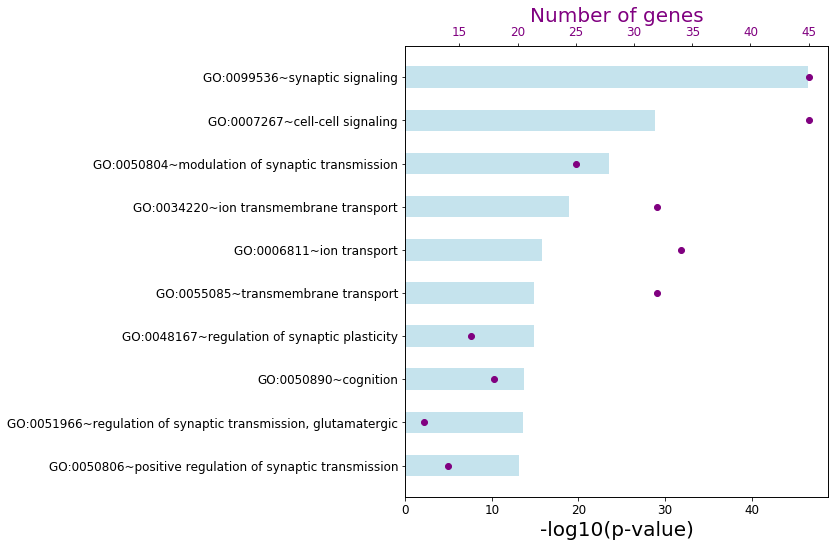

In [92]:
plot_GO_term(M8_bp_terms, M8_bp_pvals, M8_bp_counts, xlim=None, save_fig=True, fig_title="M8_GO_BP")

In [93]:
M8_mf = pd.read_csv("modules_DAVID/8_mf.txt", sep="\t")

In [94]:
CUTOFF = 10
M8_mf_terms = M8_mf["Term"][:CUTOFF]
M8_mf_pvals = M8_mf["Bonferroni"][:CUTOFF]
M8_mf_counts = M8_mf["Count"][:CUTOFF]

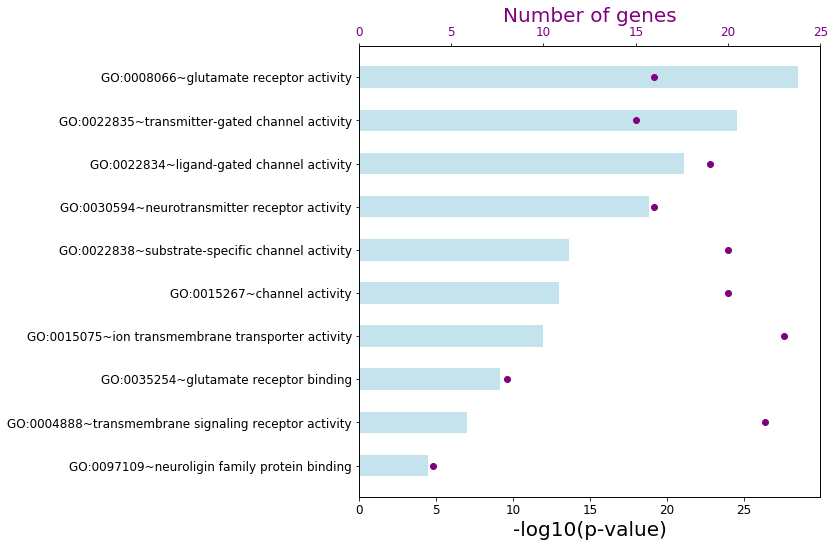

In [95]:
plot_GO_term(M8_mf_terms, M8_mf_pvals, M8_mf_counts, xlim=(0,25), save_fig=True, fig_title="M8_GO_MF")

In [96]:
M8_cc = pd.read_csv("modules_DAVID/8_cc.txt", sep="\t")

In [97]:
CUTOFF = 10
M8_cc_terms = M8_cc["Term"][:CUTOFF]
M8_cc_pvals = M8_cc["Bonferroni"][:CUTOFF]
M8_cc_counts = M8_cc["Count"][:CUTOFF]

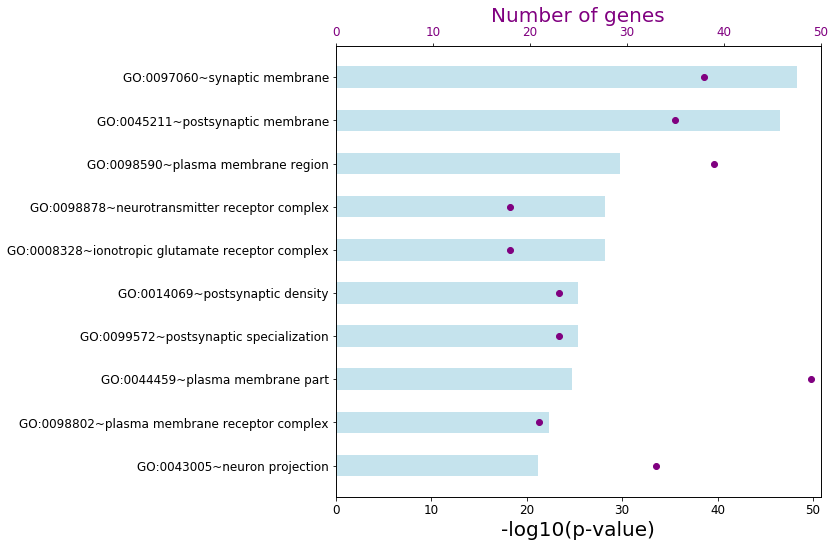

In [98]:
plot_GO_term(M8_cc_terms, M8_cc_pvals, M8_cc_counts, xlim=(0,50), save_fig=False, fig_title="M8_GO_CC")

# Enrichment analysis of genes for brain disorders

In [99]:
disease_genes_df = pd.read_csv("disease_genes.csv")

In [100]:
disease_genes_df

list  #. Of genes  \
0      Schizophrenia_GWAS          339   
1    Schizophrenia_SZGene          883   
2                 Bipolar         1192   
3  IntellectualDisability           36   
4                    ePSD          111   
5                    iPSD          182   

                                               genes  
0  ABCB9,ACD,ACTR5,ADAMTSL3,AKT3,ALDOA,AMBRA1,ANK...  
1  AANAT,ABAT,ABCA13,ABCB1,AC113554.2,ACE,ACOX1,A...  
2  SLC6A4,BDNF,COMT,DRD2,HTR2A,DAOA,MAOA,CACNA1C,...  
3  ACTB,AGTR2,AHI1,AMMECR1,ARHGEF6,ATP6AP2,ATRX,C...  
4  SHANK3,ACACA,KCNA4,GNAI2,FRS3,CNKSR2,CA2,PRR7,...  
5  FILIP1,MAG,IFT74,DTNA,CPEB2,COTL1,CSNK1A1,TPM3...

In [101]:
# get schizophrenia genes

schiz_genes = set()
for row in disease_genes_df.iloc[0:2]["genes"]:
    genes = set(row.split(","))
    schiz_genes = schiz_genes.union(genes.intersection(PPI_all_genes))
    

In [102]:
schiz_df = pd.DataFrame({"gene": list(schiz_genes)})
schiz_df = update_genes(schiz_df, "gene")
schiz_genes = set(schiz_df["gene"])
print("Schizophrenia genes not in epilepsy-autism PPI network:")
print(schiz_genes.difference(PPI_all_genes))
schiz_genes = schiz_genes.intersection(PPI_all_genes)

Schizophrenia genes not in epilepsy-autism PPI network:
set()


In [103]:
# get bipolar disorder genes

row = disease_genes_df.iloc[2]["genes"]
bp_df = pd.DataFrame({"gene": row.split(",")})
bp_df = update_genes(bp_df, "gene")
bipolar_genes = set(bp_df["gene"])
print("Bipolar disorder genes not in epilepsy-autism PPI network:")
print(bipolar_genes.difference(PPI_all_genes))
bipolar_genes = bipolar_genes.intersection(PPI_all_genes)

Replaced MKL2 with MRTFB
Replaced PARK2 with PRKN
Bipolar disorder genes not in epilepsy-autism PPI network:
{'CYCSP38', 'LOC727978', 'LOC145845', 'MIR2113', 'MIR2392', 'LOC100132713', 'PVT1', '42430', 'RNASE4', 'MsrA', 'LOC100533709', 'PCAT1', 'VEZF1P1', 'KIAA1239', 'RPSAP30', 'PPIEL', 'KIAA1009', 'ZNF259', 'AGMO(alsoknownasTMEM195)', 'LINC00992', 'PCDHA@', 'IGH', 'SCARNA17', 'JAZF1-AS1', 'SNORD114-7', 'GGTA1P', 'EXOC3-AS1', 'TCAF1', 'KCNMB2', 'BU188154', 'LINC00607', 'OC90', 'CD365222', 'HLA-F-AS1', 'CCAT1', 'PER4', 'GUCY1B2', 'ADGRA2', 'LINC00939', 'TAAR4P', 'GSTT1', 'EGFEM1P', 'LINC01370', 'WDR65', 'AW295978', 'LINC00977', 'AK094352', 'LOC220729', 'DGCR6', 'ERDA1', 'CRYBB2P1', 'BQ574468', 'C7orf63', 'GAPDHP57', 'MIR2682', 'LINC01141', 'MCM3AP-AS1', 'C14orf166B', '42705', 'DPPA2P3', 'MIR137', 'KIAA1430'}


In [104]:
# get intellectual disability genes

row = disease_genes_df.iloc[3]["genes"]
id_df = pd.DataFrame({"gene": row.split(",")})
id_df = update_genes(id_df, "gene")
id_genes = set(id_df["gene"])
print("Intellectual disability genes not in epilepsy-autism PPI network:")
print(id_genes.difference(PPI_all_genes))
id_genes = id_genes.intersection(PPI_all_genes)

Intellectual disability genes not in epilepsy-autism PPI network:
set()


In [105]:
# get excitatory post synpatic density (ePSD) genes

row = disease_genes_df.iloc[4]["genes"]
epsd_df = pd.DataFrame({"gene": row.split(",")})
epsd_df = update_genes(epsd_df, "gene")
epsd_genes = set(epsd_df["gene"])
print("ePSD genes not in epilepsy-autism PPI network:")
print(epsd_genes.difference(PPI_all_genes))
epsd_genes = epsd_genes.intersection(PPI_all_genes)  

Replaced ADSS with ADSS2
ePSD genes not in epilepsy-autism PPI network:
{'', 'SHANK3'}


In [106]:
# get inhibitory post synpatic density (iPSD) genes

row = disease_genes_df.iloc[5]["genes"]
ipsd_df = pd.DataFrame({"gene": row.split(",")})
ipsd_df = update_genes(ipsd_df, "gene")
ipsd_genes = set(ipsd_df["gene"])
print("iPSD genes not in epilepsy-autism PPI network:")
print(ipsd_genes.difference(PPI_all_genes))
ipsd_genes = ipsd_genes.intersection(PPI_all_genes)   

iPSD genes not in epilepsy-autism PPI network:
{'', 'BORCS6', 'ADGRB1', 'RAB4B-EGLN2'}


In [107]:
print("There are", len(schiz_genes), "schizophrenia genes.")
print("There are", len(bipolar_genes), "bipolar disorder genes.")
print("There are", len(id_genes), "intellectual disability genes.")
print("There are", len(epsd_genes), "ePSD genes.")
print("There are", len(ipsd_genes), "iPSD genes.")

There are 1171 schizophrenia genes.
There are 1130 bipolar disorder genes.
There are 36 intellectual disability genes.
There are 107 ePSD genes.
There are 176 iPSD genes.


In [108]:
# test enrichment for schizophrenia, bipolar disorder, intellectual disability, ePSD, and iPSD genes in each module

pvals_schiz, enrichment_schiz = test_enrichement(get_distribution_total(schiz_genes, leiden_coms), leiden_coms)
enriched_modules_schiz = get_enriched_modules(pvals_schiz, enrichment_schiz, alpha=0.05)

pvals_bp, enrichment_bp = test_enrichement(get_distribution_total(bipolar_genes, leiden_coms), leiden_coms)
enriched_modules_bp = get_enriched_modules(pvals_bp, enrichment_bp, alpha=0.05)

pvals_id, enrichment_id = test_enrichement(get_distribution_total(id_genes, leiden_coms), leiden_coms)
enriched_modules_id = get_enriched_modules(pvals_id, enrichment_id, alpha=0.05)

pvals_epsd, enrichment_epsd = test_enrichement(get_distribution_total(epsd_genes, leiden_coms), leiden_coms)
enriched_modules_epsd = get_enriched_modules(pvals_epsd, enrichment_epsd, alpha=0.05)

pvals_ipsd, enrichment_ipsd = test_enrichement(get_distribution_total(ipsd_genes, leiden_coms), leiden_coms)
enriched_modules_ipsd = get_enriched_modules(pvals_ipsd, enrichment_ipsd, alpha=0.05)

In [109]:
# enrichment for k-core genes in each module

pvals_k, enrichment_k = test_enrichement(get_distribution_total(k_core_17_genes, leiden_coms), leiden_coms)
enriched_modules_k = get_enriched_modules(pvals_k, enrichment_k, alpha=0.05)

pvals_k_DE, enrichment_k_DE = test_enrichement(get_distribution_total(k_core_17_genes.intersection(DE_genes), leiden_coms), leiden_coms)
enriched_modules_k_DE = get_enriched_modules(pvals_k_DE, enrichment_k_DE, alpha=0.05)

In [110]:
enrichment_df = pd.DataFrame({
    "E1": get_log_pvals(pvals_e1, enrichment_e1),
    "E2": get_log_pvals(pvals_e2, enrichment_e2),
    "E3": get_log_pvals(pvals_e3, enrichment_e3),
    "E4": get_log_pvals(pvals_e4, enrichment_e4),
    "A1": get_log_pvals(pvals_a1, enrichment_a1),
    "A2": get_log_pvals(pvals_a2, enrichment_a2),
    "A3": get_log_pvals(pvals_a3, enrichment_a3),
    "AS": get_log_pvals(pvals_as, enrichment_as),
    "common": get_log_pvals(pvals_c, enrichment_c),
    "DE": get_log_pvals(pvals_DE, enrichment_DE),
    "k-core": get_log_pvals(pvals_k, enrichment_k),
    "k-core + DE": get_log_pvals(pvals_k_DE, enrichment_k_DE),
    "schizophrenia": get_log_pvals(pvals_schiz, enrichment_schiz),
    "bipolar disorder": get_log_pvals(pvals_bp, enrichment_bp),
    "intellectual disability": get_log_pvals(pvals_id, enrichment_id),
    "ePSD": get_log_pvals(pvals_epsd, enrichment_epsd),
    "iPSD": get_log_pvals(pvals_ipsd, enrichment_ipsd),
})

enrichment_df = enrichment_df.transpose()
alpha_cutoff = -np.log10(0.05)
enrichment_df = enrichment_df.applymap(lambda x: x if x > alpha_cutoff or x < -alpha_cutoff else 0)

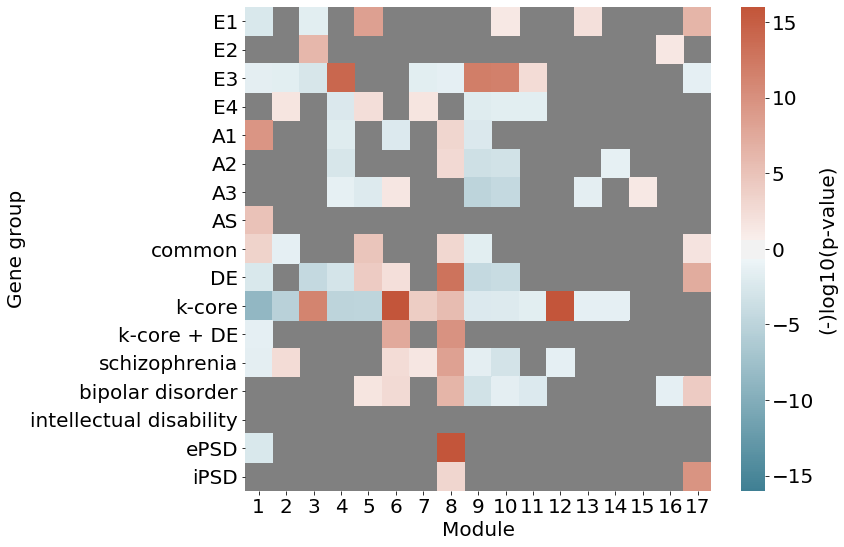

In [113]:
plt.figure(figsize=(12,8))

xticklabels = [str(i) for i in range(1, MODULE_CUTOFF+1)]
cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(enrichment_df, xticklabels = xticklabels, cbar_kws={'label': '(-)log10(p-value)'}, cmap=cmap, mask=enrichment_df == 0, vmin = -max(enrichment_df), vmax=max(enrichment_df))
ax.set_facecolor('grey')

plt.xlabel('Module')
plt.ylabel('Gene group')
plt.tight_layout()

plt.savefig(FIGURES_DIR + "/enrichment_analysis.png", dpi=300)

plt.show()